Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Epoch 1, Loss: 3.5887
Epoch 2, Loss: 2.7879
Epoch 3, Loss: 2.4247
Epoch 4, Loss: 2.1792
Epoch 5, Loss: 1.9760
Epoch 6, Loss: 1.8019
Epoch 7, Loss: 1.6445
Epoch 8, Loss: 1.5038
Epoch 9, Loss: 1.3539
Epoch 10, Loss: 1.2178
Epoch 1, Loss: 1.2135
Epoch 2, Loss: 0.9199
Epoch 3, Loss: 0.8532
Epoch 4, Loss: 0.8108
Epoch 5, Loss: 0.7793
Epoch 6, Loss: 0.7468
Epoch 7, Loss: 0.7217
Epoch 8, Loss: 0.6988
Epoch 9, Loss: 0.6777
Epoch 10, Loss: 0.6603
Epoch 1, Loss: 1.3669
Epoch 2, Loss: 0.9605
Epoch 3, Loss: 0.8048
Epoch 4, Loss: 0.6883
Epoch 5, Loss: 0.5797
Epoch 6, Loss: 0.4824
Epoch 8, Loss: 0.3071
Epoch 9, Loss: 0.2318
Epoch 10, Loss: 0.1762


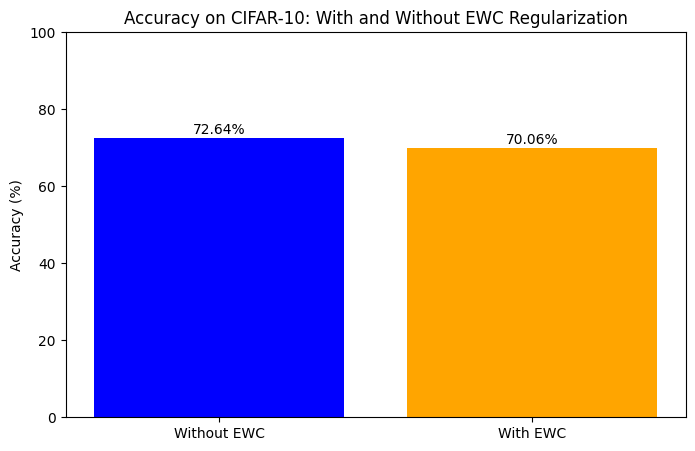

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# Data preparation
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load CIFAR-10
train_set_10 = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_set_10 = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
train_loader_10 = torch.utils.data.DataLoader(train_set_10, batch_size=128, shuffle=True)
test_loader_10 = torch.utils.data.DataLoader(test_set_10, batch_size=128, shuffle=False)

# Load CIFAR-100
train_set_100 = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform)
test_set_100 = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform)
train_loader_100 = torch.utils.data.DataLoader(train_set_100, batch_size=128, shuffle=True)
test_loader_100 = torch.utils.data.DataLoader(test_set_100, batch_size=128, shuffle=False)

# Define the CNN
class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 8 * 8, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

# Define EWC
class EWC:
    def __init__(self, model, dataloader, criterion):
        self.params = {name: param.clone().detach() for name, param in model.named_parameters()}
        self.fisher_matrix = {name: torch.zeros_like(param) for name, param in model.named_parameters()}
        model.eval()
        for X_batch, y_batch in dataloader:
            model.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            for name, param in model.named_parameters():
                if param.grad is not None:
                    self.fisher_matrix[name] += param.grad.pow(2).detach()
        for name in self.fisher_matrix:
            self.fisher_matrix[name] /= len(dataloader)

    def regularize_loss(self, model):
        loss = 0
        for name, param in model.named_parameters():
            if name in self.fisher_matrix and param.shape == self.params[name].shape:
                loss += torch.sum(self.fisher_matrix[name] * (param - self.params[name]) ** 2)
        return loss

# Training function
def train(model, dataloader, optimizer, criterion, ewc=None, lambda_ewc=0):
    model.train()
    for epoch in range(10):
        total_loss = 0
        for X_batch, y_batch in dataloader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            if ewc:
                loss += lambda_ewc * ewc.regularize_loss(model)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}, Loss: {total_loss / len(dataloader):.4f}")

# Evaluation function
def evaluate(model, dataloader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for X_batch, y_batch in dataloader:
            outputs = model(X_batch)
            _, predicted = torch.max(outputs, 1)
            total += y_batch.size(0)
            correct += (predicted == y_batch).sum().item()
    return 100 * correct / total

# Initialize models
model = CNN(num_classes=100)

# Optimizer and criterion
learning_rate = 0.001
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

# Step 1: Train on CIFAR-100
train(model, train_loader_100, optimizer, criterion)
accuracy_cifar100 = evaluate(model, test_loader_100)

# Step 2: Compute Fisher Information Matrix
ewc = EWC(model, train_loader_100, criterion)

# Step 3: Train on CIFAR-10 with EWC
model.classifier[-1] = nn.Linear(128, 10)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
train(model, train_loader_10, optimizer, criterion, ewc=ewc, lambda_ewc=100)
accuracy_cifar10_ewc = evaluate(model, test_loader_10)

# Step 4: Train on CIFAR-10 without EWC
model_no_ewc = CNN(num_classes=10)
optimizer_no_ewc = optim.Adam(model_no_ewc.parameters(), lr=learning_rate)
train(model_no_ewc, train_loader_10, optimizer_no_ewc, criterion)
accuracy_cifar10_no_ewc = evaluate(model_no_ewc, test_loader_10)

# Step 5: Plot results
accuracies = [accuracy_cifar10_no_ewc, accuracy_cifar10_ewc]
labels = ['Without EWC', 'With EWC']

plt.figure(figsize=(8, 5))
plt.bar(labels, accuracies, color=['blue', 'orange'])
plt.ylabel('Accuracy (%)')
plt.title('Accuracy on CIFAR-10: With and Without EWC Regularization')
for i, acc in enumerate(accuracies):
    plt.text(i, acc + 1, f'{acc:.2f}%', ha='center', fontsize=10)
plt.ylim(0, 100)
plt.show()
